## Data cleaning

### Set up

We first import the different libraries that we will be using for this project

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns

We import our dataset

In [2]:
data_path="data/fires-time-series.xlsx"
try:
    df=pd.read_excel(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")
df.head()

,superficie,fecha,lat,lng,idprovincia,idmunicipio,municipio
0,20.0,1980-09-18,42.428281,-6.914337,32,9,"BARCO DE VALDEORRAS, O"
1,2.0,1983-01-16,42.542185,-8.449205,36,12,COTOBADE
2,6.0,1983-01-16,42.102572,-8.415920,36,34,"NEVES, AS"
3,3.0,1983-01-17,43.629834,-7.367642,27,19,FOZ
4,40.0,1983-01-18,43.018968,-7.408954,27,11,CASTROVERDE


### Group by weeks

Agrupamos los datos y obtenemos el número total de incendios y la superficie quemada por semana.

In [3]:
# Asegurarse de que la columna 'fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Agregar columna de semana (Año-Semana)
df['semana'] = df['fecha'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana
df = df.groupby('semana').agg(
    numero_incendios=('superficie', 'count'),  # Cuenta las filas
    superficie_total=('superficie', 'sum')    # Suma la superficie
).reset_index()

# Crear rango completo de semanas desde el primer lunes de 1983 hasta la última fecha
start_date = pd.Timestamp("1983-01-01")
end_date = df['semana'].max()

# Generar rango de semanas completas
full_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Crear un DataFrame con las semanas completas
weeks_df = pd.DataFrame({'semana': full_weeks})

# Combinar con el DataFrame original (left join)
df = weeks_df.merge(df, on='semana', how='left')

# Rellenar valores NaN con 0 para las columnas numéricas
df['numero_incendios'] = df['numero_incendios'].fillna(0).astype(int)
df['superficie_total'] = df['superficie_total'].fillna(0)

# Agregar columnas de año y número de semana
df['año'] = df['semana'].dt.year
df['semana_año'] = df['semana'].dt.isocalendar().week
df['mes'] = df['semana'].dt.month

df.head()

,semana,numero_incendios,superficie_total,año,semana_año,mes
0,1983-01-03,0,0.0,1983,1,1
1,1983-01-10,2,8.0,1983,2,1
2,1983-01-17,61,937.0,1983,3,1
3,1983-01-24,75,1009.3,1983,4,1
4,1983-01-31,2,6.0,1983,5,1


### Split train and test data

Los datos para entrenamiento son el 80% inicial (1983-2011) y los de test el 20% restante (2012-2018).

In [4]:
# Dividir los datos en train y test
df_train = df[df['año'] <= 2011].reset_index(drop=True) #Modificados
df_test = df[df['año'] >= 2012].reset_index(drop=True)

# Calcular tamaños de train y test
train_size = len(df_train)
test_size = len(df_test)
total_size = len(df)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train.head(), "\n--------------\n", df_train.tail())
print("\nTest:")
print(df_test.head(), "\n--------------\n", df_test.tail()) # No se usará hasta el final


Tamaño total: 1879
Train: 1513 filas (80.52%)
Test: 366 filas (19.48%)
Train:
      semana  numero_incendios  superficie_total   año  semana_año  mes
0 1983-01-03                 0               0.0  1983           1    1
1 1983-01-10                 2               8.0  1983           2    1
2 1983-01-17                61             937.0  1983           3    1
3 1983-01-24                75            1009.3  1983           4    1
4 1983-01-31                 2               6.0  1983           5    1 
--------------
          semana  numero_incendios  superficie_total   año  semana_año  mes
1508 2011-11-28                 3             48.55  2011          48   11
1509 2011-12-05                 0              0.00  2011          49   12
1510 2011-12-12                 0              0.00  2011          50   12
1511 2011-12-19                 0              0.00  2011          51   12
1512 2011-12-26                 5             12.89  2011          52   12

Test:
      semana  n

## Train models

### Analyze train data set

Podemos realizar un breve análisis de los datos que usaremos para el entrenamiento.

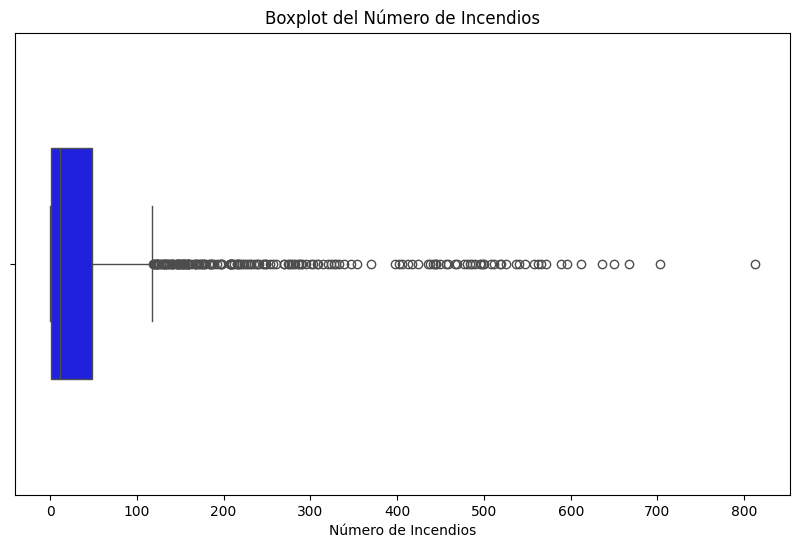

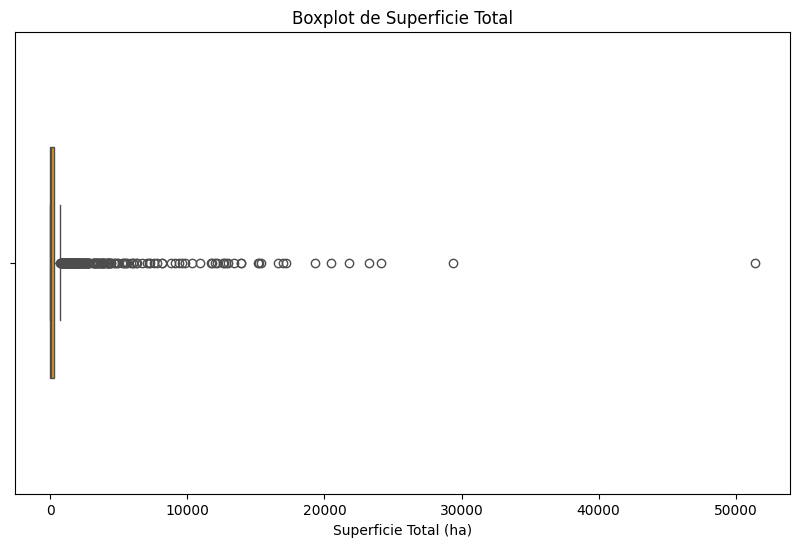

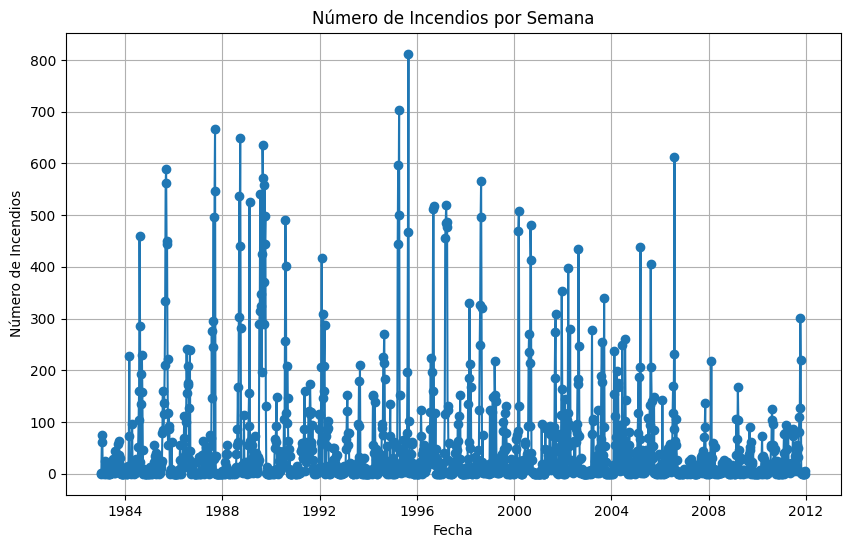

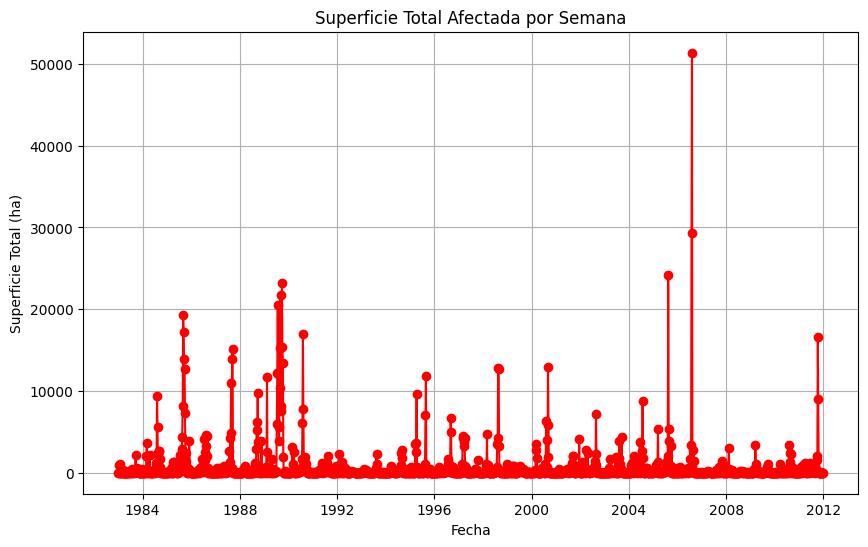

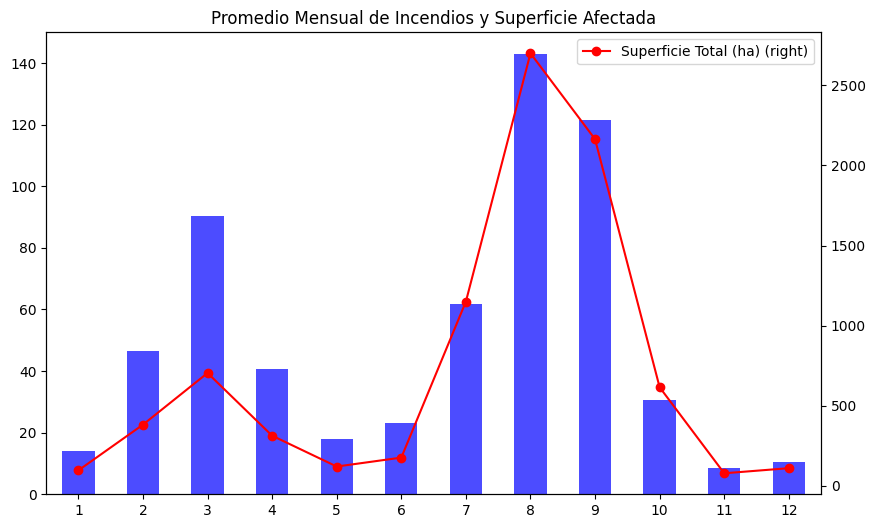

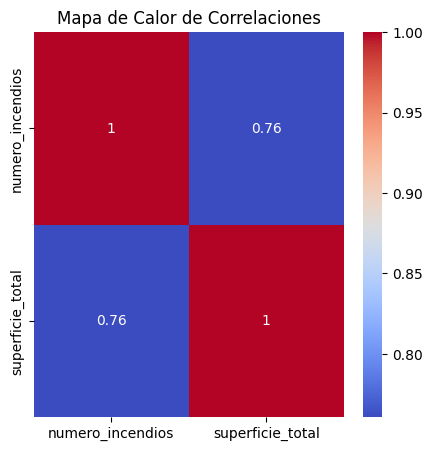

In [5]:
#TODO (Quitar seguramente o hacer manualmente con Data Wrangler)
# Posibles cosas

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x="numero_incendios", color="blue", width=0.5)
plt.title("Boxplot del Número de Incendios")
plt.xlabel("Número de Incendios")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x="superficie_total", color="orange", width=0.5)
plt.title("Boxplot de Superficie Total")
plt.xlabel("Superficie Total (ha)")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df_train["semana"], df_train["numero_incendios"], marker="o")
plt.title("Número de Incendios por Semana")
plt.xlabel("Fecha")
plt.ylabel("Número de Incendios")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_train["semana"], df_train["superficie_total"], marker="o", color="red")
plt.title("Superficie Total Afectada por Semana")
plt.xlabel("Fecha")
plt.ylabel("Superficie Total (ha)")
plt.grid()
plt.show()

df_monthly = df_train.groupby("mes")[["numero_incendios", "superficie_total"]].mean().reset_index()
plt.figure(figsize=(10, 6))
df_monthly["numero_incendios"].plot(kind="bar", color="blue", alpha=0.7, label="Número de Incendios")
df_monthly["superficie_total"].plot(kind="line", color="red", marker="o", label="Superficie Total (ha)", secondary_y=True)
plt.xticks(ticks=range(12), labels=[f'{i+1}' for i in range(12)], rotation=0)
plt.title("Promedio Mensual de Incendios y Superficie Afectada")
plt.xlabel("Mes")
plt.legend()
plt.show()


corr = df_train[['numero_incendios', 'superficie_total']].corr(numeric_only=True)
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Mapa de Calor de Correlaciones")
plt.show()




### Time series

Tendremos que hacer 3 modelos con series temporales:
- Predecir numero de incendios
- Predecir hectareas quemadas
- Predecir ambas cosas a la vez

Después introducir también variables exógenas (meteorológicas).

Definimos una función que nos permita transformar el dataframe haciendo 'windowing', indicando el número de semanas de la ventana, las variables predictoras y las variables exógenas.

In [6]:
def create_windowed_dataframe(df, n_weeks, target_vars, exogenous_vars):
    """
    Crea un DataFrame con windowing para múltiples variables objetivo y exógenas,
    conservando la columna de semanas.
    
    Args:
        df (DataFrame): DataFrame con las columnas relevantes.
        n_weeks (int): Número de semanas previas a incluir.
        target_vars (list): Variables objetivo (a predecir).
        exogenous_vars (list): Variables exógenas.
        week_col (str): Nombre de la columna que contiene las semanas.
    
    Returns:
        df_windowed (DataFrame): DataFrame con las variables de entrada, salida y columna de semanas.
    """
    data = df.copy()
    features = target_vars + exogenous_vars
    columns = ["semana"]  # Mantener la columna semana

    # Crear nombres de columnas para las semanas previas
    for week in range(-n_weeks, 0):
        columns.extend([f"{col}_week_{week}" for col in features])
    
    # Agregar columnas para las variables objetivo actuales
    columns.extend(target_vars)

    rows = []

    for i in range(n_weeks, len(data)):
        # Semana actual
        current_week = data["semana"].iloc[i]

        # Inputs: Variables de las últimas n semanas
        input_window = data[features].iloc[i-n_weeks:i].values.flatten().tolist()

        # Outputs: Variables objetivo para la semana actual
        output_window = data[target_vars].iloc[i].values.tolist()

        # Combinar inputs, outputs y la semana actual
        rows.append([current_week] + input_window + output_window)
    
    # Crear DataFrame final
    df_windowed = pd.DataFrame(rows, columns=columns)
    return df_windowed


#### Modelo 1: Número de incendios
Para el primer caso, utilizamos solo el número de incendios sin variables exógenas.

In [7]:
target_vars = ["numero_incendios"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 10  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

,semana,numero_incendios_week_-10,numero_incendios_week_-9,numero_incendios_week_-8,numero_incendios_week_-7,numero_incendios_week_-6,numero_incendios_week_-5,numero_incendios_week_-4,numero_incendios_week_-3,numero_incendios_week_-2,numero_incendios_week_-1,numero_incendios
0,2012-01-02,2,0,3,0,0,3,0,0,0,5,1
1,2012-01-09,0,3,0,0,3,0,0,0,5,1,8
2,2012-01-16,3,0,0,3,0,0,0,5,1,8,1
3,2012-01-23,0,0,3,0,0,0,5,1,8,1,16
4,2012-01-30,0,3,0,0,0,5,1,8,1,16,31


Vamos a probar a utilizar Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-1]
y_train = df_windowed_train.iloc[:, -1]
X_test = df_windowed_test.iloc[:, 1:-1]
y_test = df_windowed_test.iloc[:, -1]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score : 42.491501455380345
MAE en conjunto de test final: 11.7675


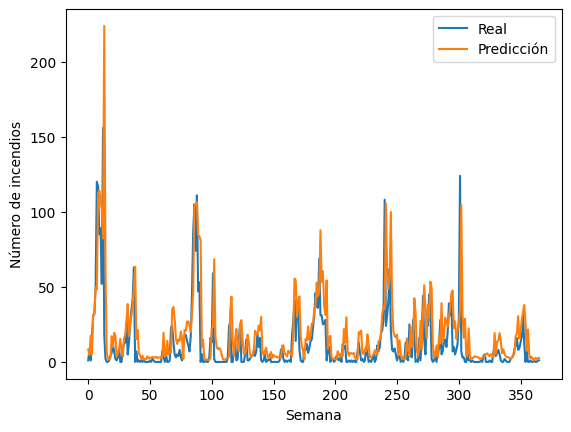

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el parámetro de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo de muestras en una hoja
}

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score : {-grid_search.best_score_}")

# Mejor modelo después de la búsqueda
best_rf_1 = grid_search.best_estimator_

# Predecir en el conjunto de test
y_pred_test = best_rf_1.predict(X_test)

# Evaluar en el conjunto de test final
final_mae = mean_absolute_error(y_test, y_pred_test)

# Resultados
print(f"MAE en conjunto de test final: {final_mae:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Error promedio de validación cruzada: 39.84118390229941
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8816  
MAE en el conjunto de test final: 9.491365432739258
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


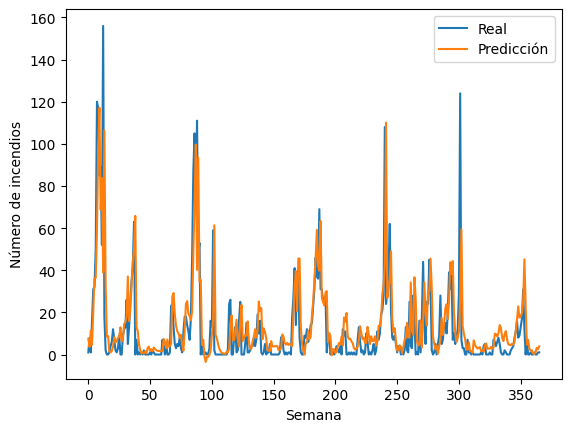

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    errors.append(mean_absolute_error(y_val_fold, y_val_pred))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(errors))

# Evaluar
loss = model.evaluate(X_test_lstm, y_test.values)
print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)


plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()


#### Modelo 2: Hectáreas Quemadas
Para el segundo caso, utilizamos solo el número de hectáreas sin variables exógenas.

In [11]:
target_vars = ["superficie_total"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 10  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

,semana,superficie_total_week_-10,superficie_total_week_-9,superficie_total_week_-8,superficie_total_week_-7,superficie_total_week_-6,superficie_total_week_-5,superficie_total_week_-4,superficie_total_week_-3,superficie_total_week_-2,superficie_total_week_-1,superficie_total
0,2012-01-02,3.30,0.00,11.13,0.00,0.00,48.55,0.00,0.00,0.00,12.89,1.70
1,2012-01-09,0.00,11.13,0.00,0.00,48.55,0.00,0.00,0.00,12.89,1.70,15.59
2,2012-01-16,11.13,0.00,0.00,48.55,0.00,0.00,0.00,12.89,1.70,15.59,2.11
3,2012-01-23,0.00,0.00,48.55,0.00,0.00,0.00,12.89,1.70,15.59,2.11,144.27
4,2012-01-30,0.00,48.55,0.00,0.00,0.00,12.89,1.70,15.59,2.11,144.27,106.29


Vamos a probar a utilizar Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-1]
y_train = df_windowed_train.iloc[:, -1]
X_test = df_windowed_test.iloc[:, 1:-1]
y_test = df_windowed_test.iloc[:, -1]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mejor score : 699.6654755899871
MAE en conjunto de test final: 466.8151


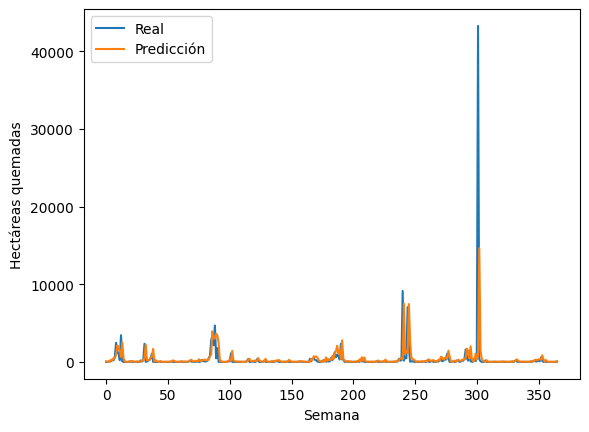

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el parámetro de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo de muestras en una hoja
}

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score : {-grid_search.best_score_}")

# Mejor modelo después de la búsqueda
best_rf_1 = grid_search.best_estimator_

# Predecir en el conjunto de test
y_pred_test = best_rf_1.predict(X_test)

# Evaluar en el conjunto de test final
final_mae = mean_absolute_error(y_test, y_pred_test)

# Resultados
print(f"MAE en conjunto de test final: {final_mae:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Error promedio de validación cruzada: 672.8302701233904
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284.8993  
MAE en el conjunto de test final: 337.776611328125
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


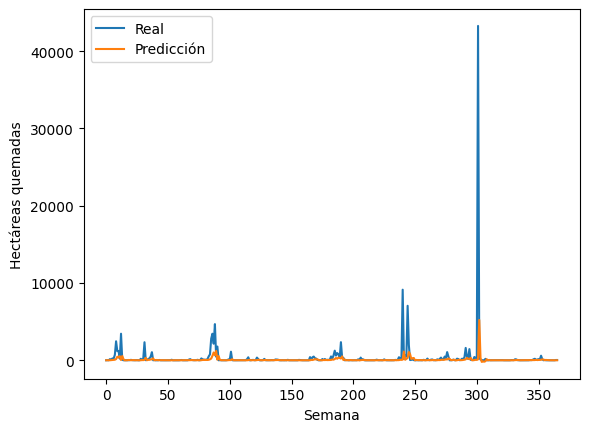

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    errors.append(mean_absolute_error(y_val_fold, y_val_pred))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(errors))

# Evaluar
loss = model.evaluate(X_test_lstm, y_test.values)
print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)


plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


#### Modelo 3: Número de incendios y hectáreas quemadas

In [15]:
target_vars = ["numero_incendios", "superficie_total"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 5  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

,semana,numero_incendios_week_-5,superficie_total_week_-5,numero_incendios_week_-4,superficie_total_week_-4,numero_incendios_week_-3,superficie_total_week_-3,numero_incendios_week_-2,superficie_total_week_-2,numero_incendios_week_-1,superficie_total_week_-1,numero_incendios,superficie_total
0,2012-01-02,3.0,48.55,0.0,0.00,0.0,0.00,0.0,0.00,5.0,12.89,1.0,1.70
1,2012-01-09,0.0,0.00,0.0,0.00,0.0,0.00,5.0,12.89,1.0,1.70,8.0,15.59
2,2012-01-16,0.0,0.00,0.0,0.00,5.0,12.89,1.0,1.70,8.0,15.59,1.0,2.11
3,2012-01-23,0.0,0.00,5.0,12.89,1.0,1.70,8.0,15.59,1.0,2.11,16.0,144.27
4,2012-01-30,5.0,12.89,1.0,1.70,8.0,15.59,1.0,2.11,16.0,144.27,31.0,106.29


Vamos a probar a utilizar Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-2]
y_train = df_windowed_train.iloc[:, -2:]
print(y_train)
X_test = df_windowed_test.iloc[:, 1:-2]
y_test = df_windowed_test.iloc[:, -2:]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

      numero_incendios  superficie_total
0                  2.0              3.00
1                  1.0              9.00
2                  0.0              0.00
3                  7.0             30.50
4                 24.0            347.50
...                ...               ...
1503               3.0             48.55
1504               0.0              0.00
1505               0.0              0.00
1506               0.0              0.00
1507               5.0             12.89

[1508 rows x 2 columns]


Validación con TimeSeriesSplit

MAE promedio por variable objetivo: [ 41.88840583 725.8677825 ]
MAE en conjunto de test final (numero_incendios): 13.9412
MAE en conjunto de test final (superficie_total): 500.5513


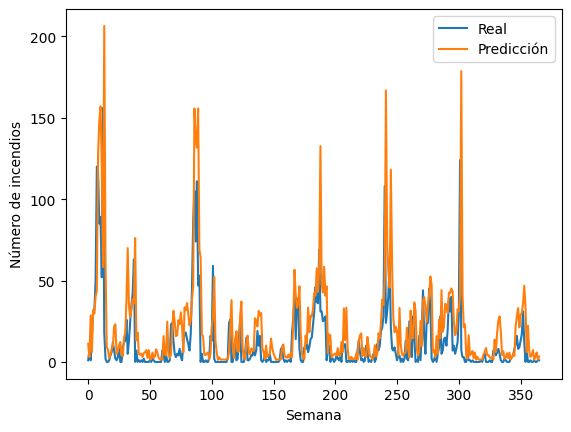

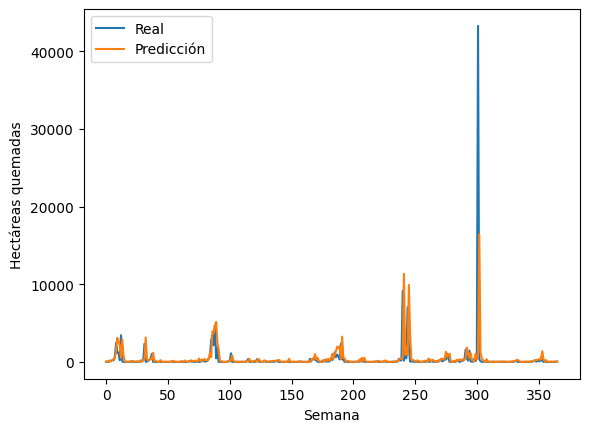

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define el modelo con hiperparámetros elegidos
rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
))

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Para almacenar los errores en cada split
mae_scores = []

# Realizar la validación cruzada manual
for train_index, val_index in tscv.split(X_train):
    # Dividir los datos en entrenamiento y validación utilizando índices posicionales
    X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entrenar el modelo
    rf.fit(X_train_split, y_train_split)
    
    # Hacer predicciones
    y_pred = rf.predict(X_val_split)
    # Calcular MAE para ambas variables objetivo
    mae_split = mean_absolute_error(y_val_split, y_pred, multioutput='raw_values')  # Devuelve un array con el MAE de cada salida
    mae_scores.append(mae_split)

# Calcular el promedio del MAE para cada variable objetivo
mean_mae = np.mean(mae_scores, axis=0)

print(f"MAE promedio por variable objetivo: {mean_mae}")

# Predecir en el conjunto de test
y_pred_test = rf.predict(X_test)

# Evaluar en el conjunto de test final
final_mae1 = mean_absolute_error(y_test["numero_incendios"], y_pred_test[:, 0])
final_mae2 = mean_absolute_error(y_test["superficie_total"], y_pred_test[:, 1])

# Resultados
print(f"MAE en conjunto de test final (numero_incendios): {final_mae1:.4f}")
print(f"MAE en conjunto de test final (superficie_total): {final_mae2:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

# plt.plot(y_test, label="Real")
# plt.plot(y_pred_test, label="Predicción")
# plt.legend()
# plt.show()

plt.figure()
plt.plot(y_test["numero_incendios"].values, label="Real")
plt.plot(y_pred_test[:, 0], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

plt.figure()
plt.plot(y_test["superficie_total"].values, label="Real")
plt.plot(y_pred_test[:, 1], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Error promedio de validación cruzada: [ 54.7285305  654.64404577]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Error num incendios: 15.9701065548945
Error superficie: 338.1770553541607


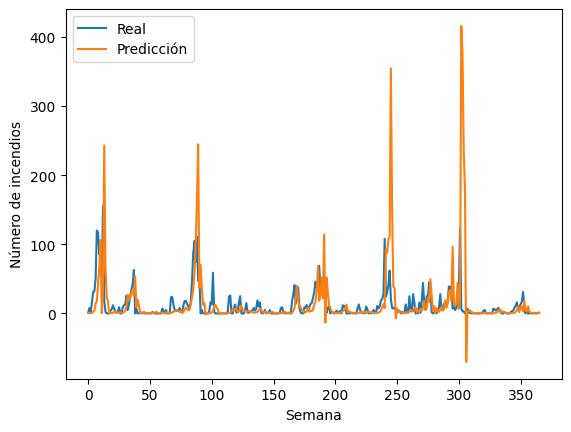

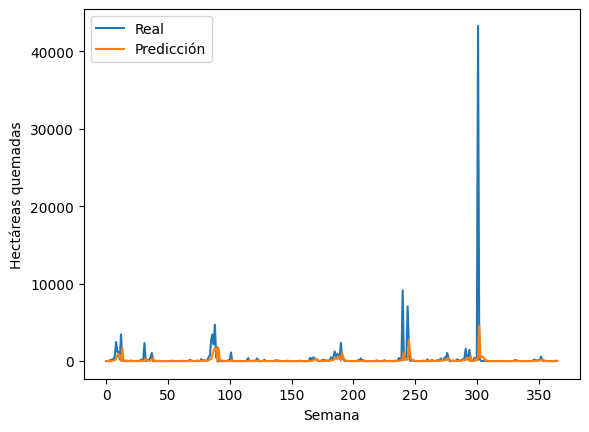

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

y_train_lstm = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))
# print("X_train:", X_train_lstm)

y_test_lstm = y_test.values.reshape((y_test.shape[0], y_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train_lstm[train_idx], y_train_lstm[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(2) # Vamos a obtener 2 salidas
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    y_val_fold = np.array(y_val_fold).reshape(-1, 2)
    y_val_fold = pd.DataFrame(y_val_fold, columns=['numero_incendios', 'superficie_total'])
    errors.append(mean_absolute_error(y_val_fold, y_val_pred, multioutput='raw_values'))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(np.array(errors), axis=0))

# Evaluar
# print("y_test", y_test.values)
# loss = model.evaluate(X_test_lstm, y_test.values)
# print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)

error_num_incendios = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])  # error para la primera variable
error_superficie = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])     # error para la segunda variable
# Imprimir los resultados
print(f"Error num incendios: {error_num_incendios}")
print(f"Error superficie: {error_superficie}")

# plt.plot(y_test.values, label="Real")
# plt.plot(y_pred, label="Predicción")
# plt.legend()
# plt.show()

plt.figure()
plt.plot(y_test["numero_incendios"].values, label="Real")
plt.plot(y_pred[:, 0], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

plt.figure()
plt.plot(y_test["superficie_total"].values, label="Real")
plt.plot(y_pred[:, 1], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()

In [19]:
# plt.figure()
# plt.plot(y_test["numero_incendios"].values, label="Real")
# plt.plot(y_pred_test[:, 0], label="Predicción")
# plt.legend()
# plt.xlabel("Semana")
# plt.ylabel("Número de incendios")
# plt.show()

# plt.figure()
# plt.plot(y_test["superficie_total"].values, label="Real")
# plt.plot(y_pred_test[:, 1], label="Predicción")
# plt.legend()
# plt.xlabel("Semana")
# plt.ylabel("Hectáreas quemadas")
# plt.show()

## Performances

In [20]:
#TODO

## Test Model


In [21]:
#TODO